# **DENMARK RBC MODEL**
By Camila GUEVARA, Merve YILMAZ, and Gaia BECHARA.

This paper aims to compute and forcast a Real Business Cycle Model for the Denmark economy between the years 1950 to 2023.


### **Literature Review**
Dynamic Stochastic General Equilibrium (DSGE) models have become essential tools for understanding economic fluctuations in various economies, including small open economies like Denmark. This literature review explores two key articles that contribute to the understanding of business cycles in the Danish economy through the lens of DSGE models.
Pedersen and Ravn (2013) investigates the driving forces behind the business cycle in Denmark, employing a DSGE model tailored to the characteristics of a small open economy. The study likely delves into the specific features of the Danish economic landscape, considering factors such as trade openness, exchange rate dynamics, and international spillovers. The unique contribution of the article is identifying the main determinants of the business cycle in Denmark by discussing the role of external shocks and global economic conditions and assessing the effectiveness of monetary and fiscal policies in stabilizing the economy.
Pedersen (2016), on the other hand, extends the analysis by incorporating additional features into the DSGE model, focusing on housing, banking, and financial frictions. Such extensions are crucial for capturing the intricacies of the Danish economy, where factors like the housing market and financial sector play pivotal roles. Thus, this study diverges from the former by exploring the interactions between the banking sector and the broader economy and by assessing the implications of financial frictions on the transmission of shocks.

### **Preliminars**


In [1]:
pip install tsdisagg

In [2]:
import gEconpy as ge
import gEconpy.plotting as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsdisagg import disaggregate_series
import statsmodels.api as sm


In [3]:
def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names
def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")
            
    if isinstance(df, pd.Series):
        df = df.to_frame()
        
    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)
            
        print(series.center(110))
        print(('=' * 110))
        line = 'Specification' + ' ' * 15 + 'Coeff' + ' ' * 10 + 'Statistic' + ' ' * 5 + 'P-value' + ' ' * 6 + 'Lags' + ' ' * 6 + '1%'
        line += ' ' * 10 + '5%' + ' ' * 8 + '10%'
        print(line)
        print(('-' * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)
                    
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()

def plot_df(df, **plot_kwargs):
    fig = plt.figure(figsize=(14,6), dpi=144)
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=df.shape[1])

    for loc, var in zip(plot_locs, df):
        axis = fig.add_subplot(gs[loc])
        df[var].plot(ax=axis, **plot_kwargs)
        axis.set_title(var)

    fig.tight_layout()
    plt.show()

## **Importing and Processing the Data**
For this estimation, we will look at different variables fundamental in the Business Cycle analysis. Data are downloaded from the FRED, OCDE, and World Bank databases.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 768 entries, 1950-01-01 to 2023-07-01
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Bonds       147 non-null    float64
 1   Y           115 non-null    float64
 2   C           115 non-null    float64
 3   Kformation  115 non-null    float64
 4   stock       70 non-null     float64
 5   r           755 non-null    float64
 6   Exports     115 non-null    float64
 7   Imports     115 non-null    float64
dtypes: float64(8)
memory usage: 54.0 KB


,Bonds,Y,C,Kformation,stock,r,Exports,Imports
DATE,,,,,,,,
1950-01-01,NaN,NaN,NaN,NaN,203497.859375,NaN,NaN,NaN
1951-01-01,NaN,NaN,NaN,NaN,206158.671875,NaN,NaN,NaN
1952-01-01,NaN,NaN,NaN,NaN,208901.093750,NaN,NaN,NaN
1953-01-01,NaN,NaN,NaN,NaN,214274.093750,NaN,NaN,NaN
1954-01-01,NaN,NaN,NaN,NaN,220242.234375,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-10-01,2.420667,5.719180e+11,2.528550e+11,1.385479e+11,NaN,1.25,3.607410e+11,3.201785e+11
2022-11-01,NaN,NaN,NaN,NaN,NaN,1.25,NaN,NaN
2023-01-01,2.509667,5.779868e+11,2.534612e+11,1.187667e+11,NaN,NaN,3.741787e+11,3.156046e+11


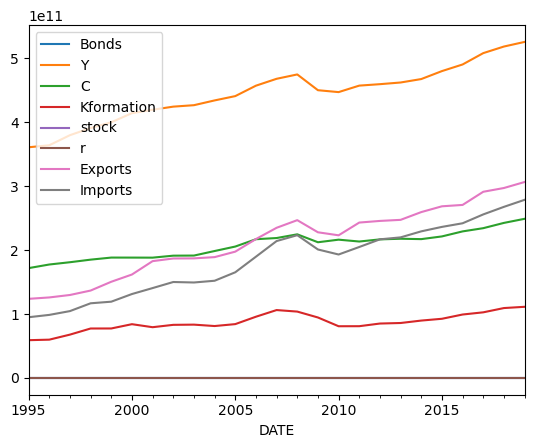

In [4]:
from pandas_datareader.fred import FredReader
fred_indicators = ['IRLTLT01DKQ156N', 'NAEXKP01DKQ189S', 'NAEXKP02DKQ189S', 'NAEXKP04DKQ189S', 'RKNANPDKA666NRUG', 'DNKLOCOSTORSTM', 'NAEXKP06DKQ652S', 'NAEXKP07DKQ652S']

df = FredReader(symbols=fred_indicators, start='1900-01-01', end=None, freq ='Q').read()

df.rename(columns={
    'IRLTLT01DKQ156N': 'Bonds', #monthly 
    'NAEXKP01DKQ189S': 'Y',
    'NAEXKP02DKQ189S': 'C',
    'NAEXKP04DKQ189S': 'Kformation',
    'RKNANPDKA666NRUG': 'stock', #annual
    'DNKLOCOSTORSTM': 'r', #monthly 
    'NAEXKP06DKQ652S': 'Exports',
    'NAEXKP07DKQ652S': 'Imports'
}, inplace=True)
df.to_csv('custom_df.csv')
df.dropna().plot()
df.info()
df

In [5]:
stock = df['stock']
#setting it up in years so it stops giving me missing values error since im going from low to higher frequency with stocks 
stock = df['stock'].resample('YS').last().dropna()
stock_quarterly = disaggregate_series(stock, target_freq='QS', agg_func='last')
r = df['r'].dropna()
def compound_interest(monthly_interests):
    quarterly_interest = (1 + monthly_interests).prod() - 1
    return quarterly_interest
r_decimal = r.mul(1 / 100)
r_quarterly = r_decimal.resample('QS').agg(compound_interest)
r_quarterly = r_quarterly + 1
r_quarterly
Br = df['Bonds'].dropna()
def compound_interest(monthly_interests):
    quarterly_interest = (1 + monthly_interests).prod() - 1
    return quarterly_interest
Br_decimal = Br.mul(1 / 100)
Br_quarterly = Br_decimal.resample('QS').agg(compound_interest)
Br_quarterly = Br_quarterly + 1
Br_quarterly

DATE
1987-01-01    1.114351
1987-04-01    1.111149
1987-07-01    1.111370
1987-10-01    1.114504
1988-01-01    1.102015
                ...   
2022-07-01    1.017203
2022-10-01    1.024207
2023-01-01    1.025097
2023-04-01    1.025690
2023-07-01    1.027630
Freq: QS-JAN, Name: Bonds, Length: 147, dtype: float64

In [6]:
df1 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/ANHRS/DNK.DE+TE.A/OECD?contentType=csv')
df1.to_csv('df1.csv')
df1 = df1[df1['Employment status'] == 'Total employment']
hours = df1.loc[:,['Time','Value']]
hours = hours.rename(columns= {'Value': 'N'})
hours['Time'] = pd.to_datetime(hours['Time'], format='%Y')
hours.set_index('Time', inplace=True)
quarterly_N = disaggregate_series(hours, target_freq='QS', agg_func='sum')
quarterly_N

1970-01-01    462.788670
1970-04-01    462.208044
1970-07-01    461.046792
1970-10-01    459.304914
1971-01-01    456.982409
                 ...    
2021-10-01    342.374966
2022-01-01    342.655797
2022-04-01    342.866420
2022-07-01    343.006836
2022-10-01    343.077043
Freq: QS-OCT, Name: N, Length: 212, dtype: float64

In [7]:
df1.dropna(inplace=True) 
print("Remaining missing values:", df1.isnull().sum().sum())

Remaining missing values: 0


In [8]:
df2 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/EAR_MEI/LCEAMN01_IXOB+LCEAMN01_IXOBSA+LCEAPR_IXOBSA.DNK.Q/OECD?contentType=csv', parse_dates=['Time'], infer_datetime_format=True)
df2.to_csv('df2.csv')
df2 = df2[df2['Subject'] == 'Manufacturing, Index']
wages = df2.loc[:,['Time','Value']]
wages = wages.rename(columns= {'Value': 'w'})
wages['Time'] = wages['Time'].apply(lambda x: x[3:] + "-" + "Q" + x[1])
wages['Time'] = pd.to_datetime(wages['Time'])
wages.set_index('Time', inplace=True)
wages.head()

C:\Users\90505\AppData\Local\Temp\ipykernel_9460\2957788866.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df2 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/EAR_MEI/LCEAMN01_IXOB+LCEAMN01_IXOBSA+LCEAPR_IXOBSA.DNK.Q/OECD?contentType=csv', parse_dates=['Time'], infer_datetime_format=True)
C:\Users\90505\AppData\Local\Temp\ipykernel_9460\2957788866.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/EAR_MEI/LCEAMN01_IXOB+LCEAMN01_IXOBSA+LCEAPR_IXOBSA.DNK.Q/OECD?contentType=csv', parse_dates=['Time'], infer_datetime_format=True)
C:\Users\90505\AppData\Local\Temp\ipyke

,w
Time,
1971-01-01,6.801153
1971-04-01,7.283459
1971-07-01,7.472557
1971-10-01,7.702024
1972-01-01,7.810383


In [9]:
df_quarterly = pd.DataFrame()

In [10]:
df_quarterly['Br_quarterly'] = Br_quarterly
df_quarterly['r_quarterly'] = r_quarterly
df_quarterly['stock_quarterly'] = stock_quarterly
C = df['C']
df_quarterly['C_quarterly'] = C
Y = df['Y']
df_quarterly['Y_quarterly'] = Y
K = df['Kformation']
df_quarterly['K_quarterly'] = K
EX = df['Exports']
df_quarterly['EX_quarterly'] = EX
IM = df['Imports']
df_quarterly['IM_quarterly'] = IM
df_quarterly

,Br_quarterly,r_quarterly,stock_quarterly,C_quarterly,Y_quarterly,K_quarterly,EX_quarterly,IM_quarterly
DATE,,,,,,,,
1987-01-01,1.114351,1.225043,799708.218750,NaN,NaN,NaN,NaN,NaN
1987-04-01,1.111149,1.225043,806198.625000,NaN,NaN,NaN,NaN,NaN
1987-07-01,1.111370,1.225043,812689.031250,NaN,NaN,NaN,NaN,NaN
1987-10-01,1.114504,1.225043,819179.437500,NaN,NaN,NaN,NaN,NaN
1988-01-01,1.102015,1.225043,824458.390625,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-07-01,1.017203,1.006500,NaN,2.535687e+11,5.704050e+11,1.220930e+11,3.617697e+11,3.143486e+11
2022-10-01,1.024207,1.025156,NaN,2.528550e+11,5.719180e+11,1.385479e+11,3.607410e+11,3.201785e+11
2023-01-01,1.025097,NaN,NaN,2.534612e+11,5.779868e+11,1.187667e+11,3.741787e+11,3.156046e+11


In [11]:
merged = df_quarterly.join([quarterly_N, wages])
merged

,Br_quarterly,r_quarterly,stock_quarterly,C_quarterly,Y_quarterly,K_quarterly,EX_quarterly,IM_quarterly,N,w
DATE,,,,,,,,,,
1987-01-01,1.114351,1.225043,799708.218750,NaN,NaN,NaN,NaN,NaN,376.969796,36.85957
1987-04-01,1.111149,1.225043,806198.625000,NaN,NaN,NaN,NaN,NaN,374.055140,38.62382
1987-07-01,1.111370,1.225043,812689.031250,NaN,NaN,NaN,NaN,NaN,371.798882,38.72432
1987-10-01,1.114504,1.225043,819179.437500,NaN,NaN,NaN,NaN,NaN,370.201021,39.53945
1988-01-01,1.102015,1.225043,824458.390625,NaN,NaN,NaN,NaN,NaN,369.261557,39.55061
...,...,...,...,...,...,...,...,...,...,...
2022-07-01,1.017203,1.006500,NaN,2.535687e+11,5.704050e+11,1.220930e+11,3.617697e+11,3.143486e+11,343.006836,117.93010
2022-10-01,1.024207,1.025156,NaN,2.528550e+11,5.719180e+11,1.385479e+11,3.607410e+11,3.201785e+11,343.077043,118.15920
2023-01-01,1.025097,NaN,NaN,2.534612e+11,5.779868e+11,1.187667e+11,3.741787e+11,3.156046e+11,NaN,118.84670


In [12]:
merged.dropna(inplace=True) 
print("Remaining missing values:", merged.isnull().sum().sum())
merged.head()

Remaining missing values: 0


,Br_quarterly,r_quarterly,stock_quarterly,C_quarterly,Y_quarterly,K_quarterly,EX_quarterly,IM_quarterly,N,w
DATE,,,,,,,,,,
1995-01-01,1.089600,1.168650,939142.859375,1.717697e+11,3.608200e+11,5.903179e+10,1.237207e+11,9.494988e+10,353.569687,52.22259
1995-04-01,1.084437,1.191016,943527.093750,1.737711e+11,3.597877e+11,5.976629e+10,1.213563e+11,9.632093e+10,355.063215,52.76544
1995-07-01,1.080877,1.165894,947911.328125,1.746535e+11,3.612882e+11,6.266278e+10,1.207843e+11,9.678716e+10,355.532891,53.25401
1995-10-01,1.075830,1.146620,952295.562500,1.750917e+11,3.639317e+11,6.607297e+10,1.221478e+11,9.977737e+10,354.978715,53.74258
1996-01-01,1.073490,1.122160,957127.187500,1.774266e+11,3.639864e+11,5.985612e+10,1.259050e+11,9.859263e+10,353.400688,54.28543


Br_quarterly


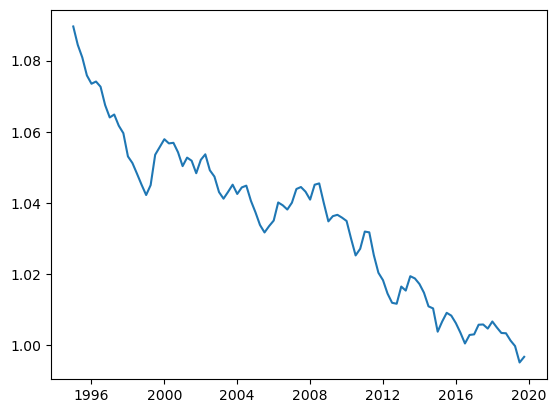

r_quarterly


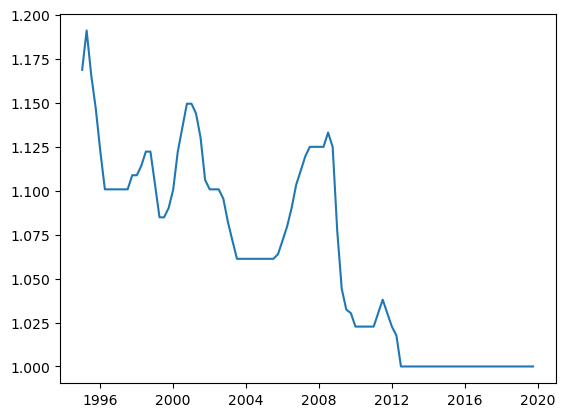

stock_quarterly


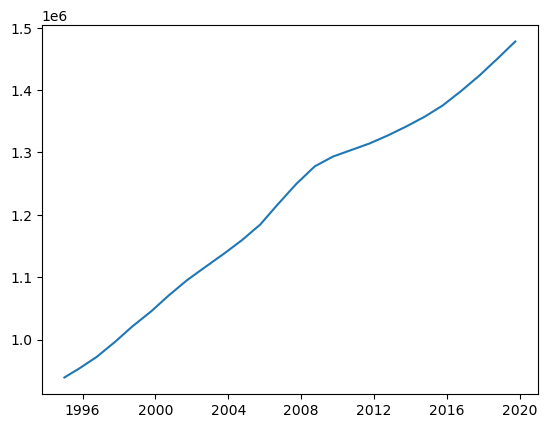

C_quarterly


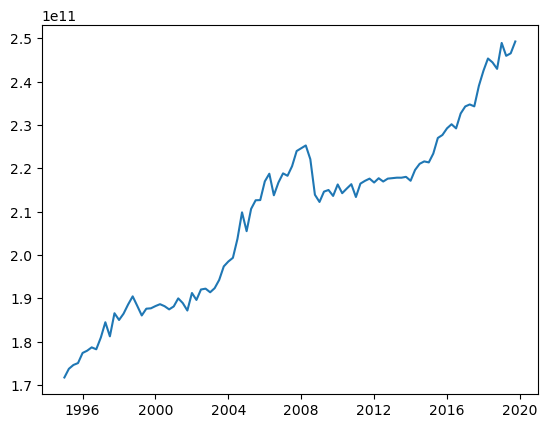

Y_quarterly


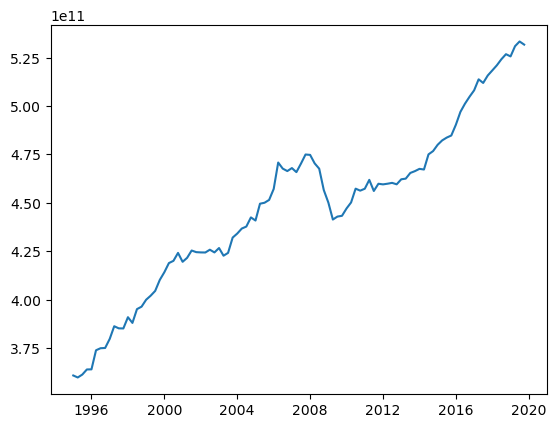

K_quarterly


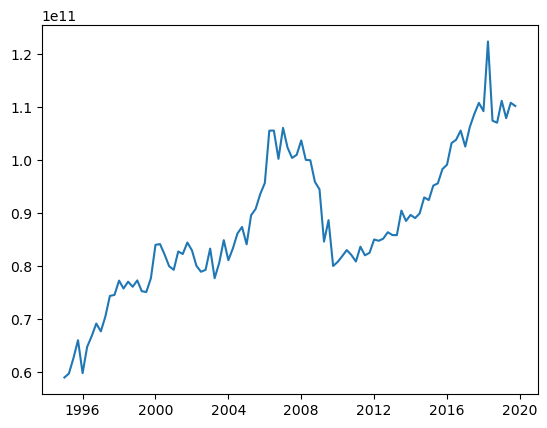

EX_quarterly


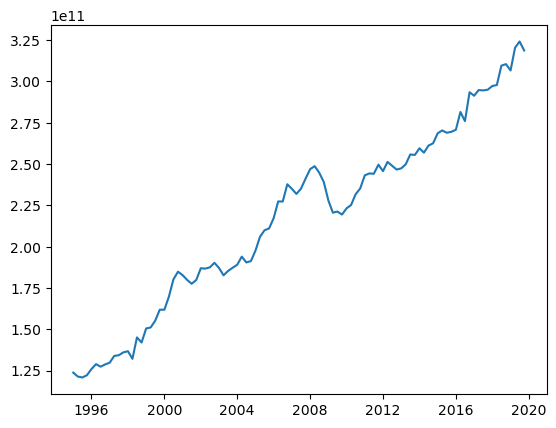

IM_quarterly


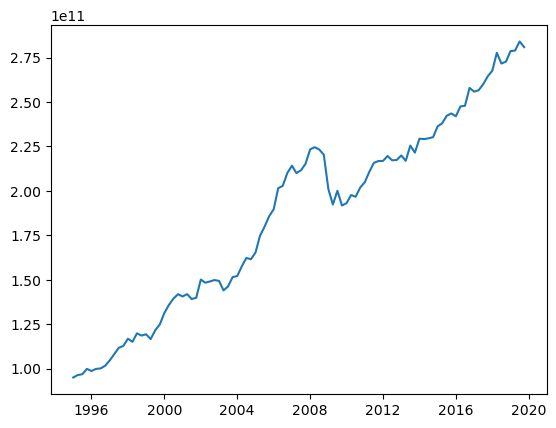

N


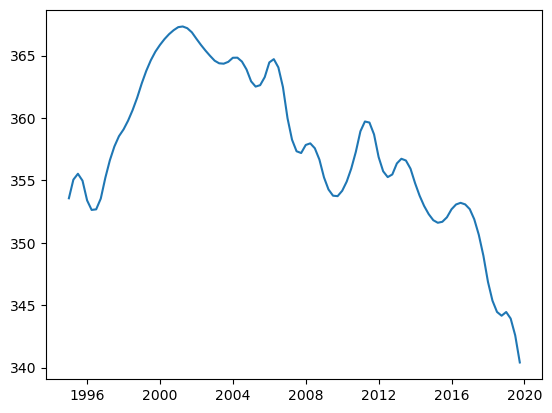

w


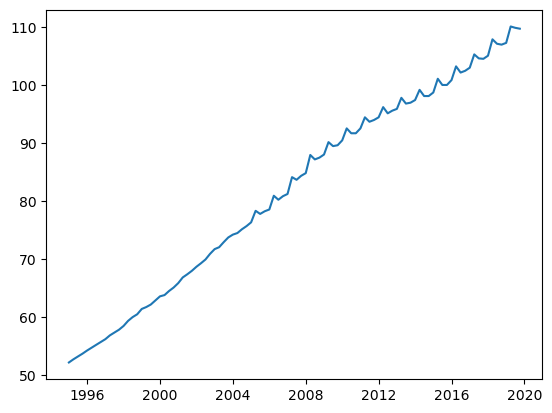

In [13]:
for columns in merged.columns:
    print(columns)
    column_data = merged[columns].dropna()
    plt.plot(column_data, label=columns)
    plt.show()

<Axes: xlabel='DATE', ylabel='Resid'>

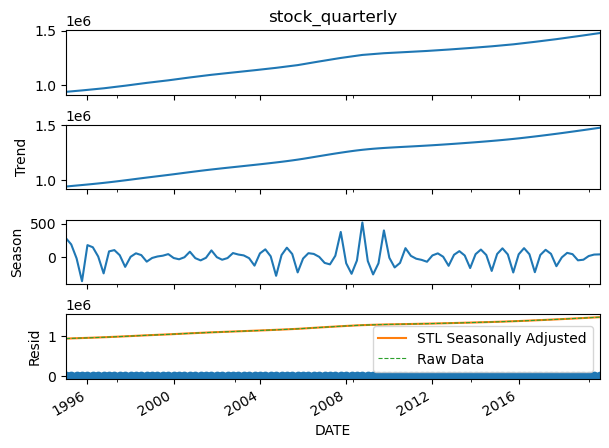

In [14]:
#Let's start with stock, aka investment 
stl_res= sm.tsa.STL(merged.stock_quarterly.dropna(), period=4).fit()
stl_res.plot()
#actual detrending 
(merged['stock_quarterly'].dropna() - stl_res.seasonal).plot(label = 'STL Seasonally Adjusted', legend=True)
merged['stock_quarterly']=merged['stock_quarterly']-stl_res.seasonal
merged['stock_quarterly'].dropna().plot(ls='--', lw=0.8, label='Raw Data', legend=True)

<Axes: xlabel='DATE', ylabel='Resid'>

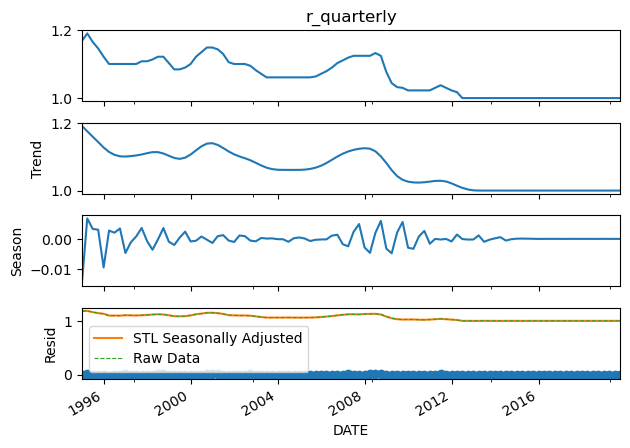

In [15]:
#now for r
stl_res= sm.tsa.STL(merged.r_quarterly.dropna(), period=4).fit()
stl_res.plot()
#actual detrending 
(merged['r_quarterly'].dropna() - stl_res.seasonal).plot(label = 'STL Seasonally Adjusted', legend=True)
merged['r_quarterly']=merged['r_quarterly']-stl_res.seasonal
merged['r_quarterly'].dropna().plot(ls='--', lw=0.8, label='Raw Data', legend=True)

<Axes: xlabel='DATE', ylabel='Resid'>

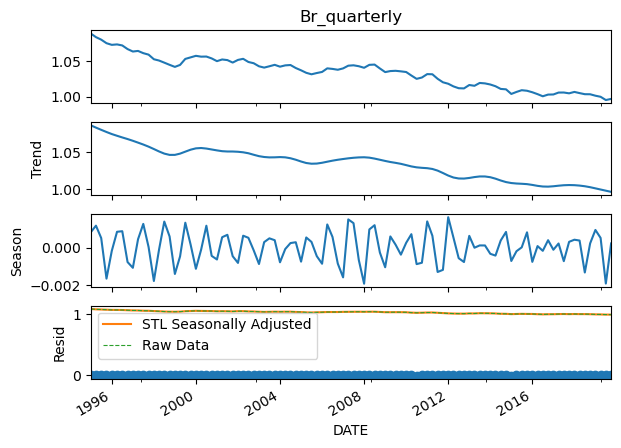

In [16]:
#finally, for bonds 
stl_res= sm.tsa.STL(merged.Br_quarterly.dropna(), period=4).fit()
stl_res.plot()
#actual detrending 
(merged['Br_quarterly'].dropna() - stl_res.seasonal).plot(label = 'STL Seasonally Adjusted', legend=True)
merged['Br_quarterly']=merged['Br_quarterly']-stl_res.seasonal
merged['Br_quarterly'].dropna().plot(ls='--', lw=0.8, label='Raw Data', legend=True)

Seasonal adjustment is done, moving on to de-trending.
Let's start with everything but the rates 

<Axes: xlabel='DATE', ylabel='Resid'>

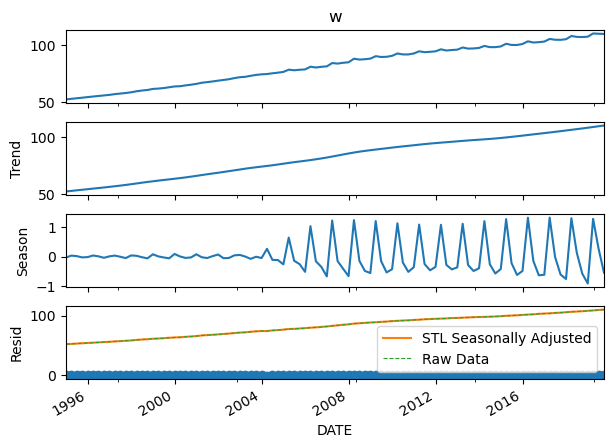

In [17]:
#lastly, for wage 
stl_res= sm.tsa.STL(merged.w.dropna(), period=4).fit()
stl_res.plot()
#actual detrending 
(merged['w'].dropna() - stl_res.seasonal).plot(label = 'STL Seasonally Adjusted', legend=True)
merged['w']=merged['w']-stl_res.seasonal
merged['w'].dropna().plot(ls='--', lw=0.8, label='Raw Data', legend=True)

<Axes: xlabel='DATE'>

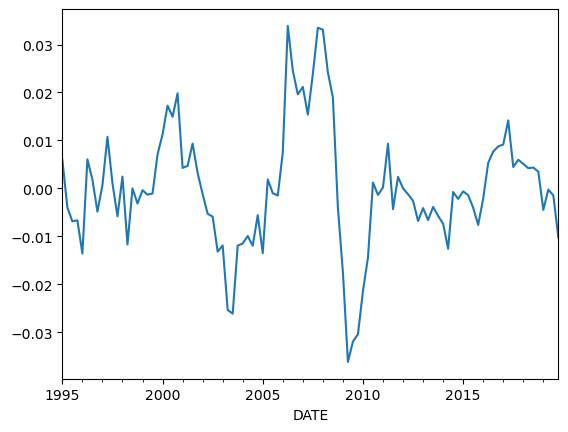

In [18]:
#starting with Y 
LogY = np.log(merged['Y_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogY)
LogY = cycle
LogY.plot()

<Axes: xlabel='DATE'>

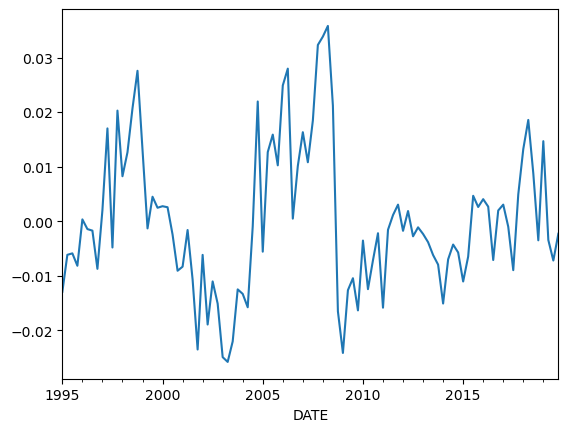

In [19]:
#now C  
LogC = np.log(merged['C_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogC)
C = LogC = cycle
C.plot()

<Axes: xlabel='DATE'>

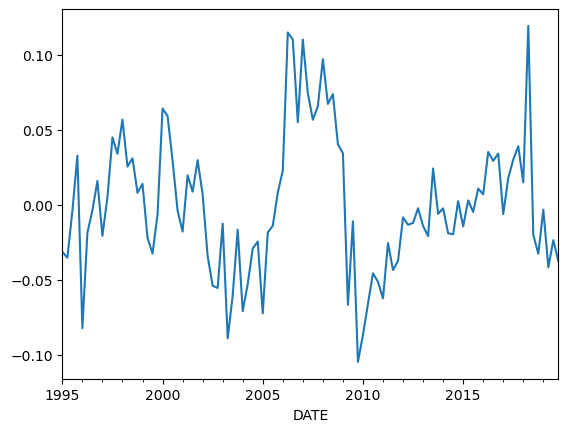

In [20]:
#now K
LogK = np.log(merged['K_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogK)
K = LogK = cycle
K.plot()

In [21]:
#de-trending rates:
merged['r_quarterly'] = merged['r_quarterly'] - merged['r_quarterly'].mean()
merged['Br_quarterly'] = merged['Br_quarterly'] - merged['Br_quarterly'].mean()

<Axes: xlabel='DATE'>

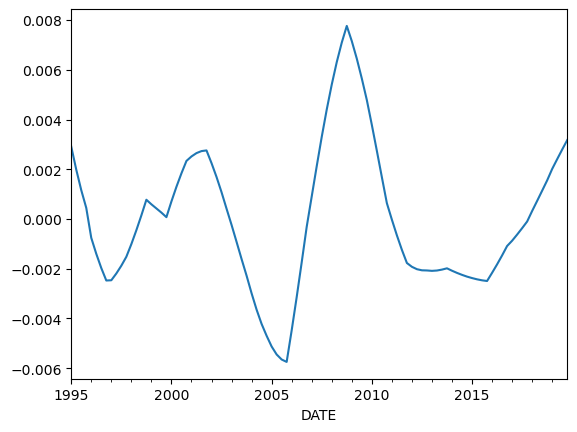

In [22]:
merged['stock_quarterly'] = merged['stock_quarterly'].dropna()
LogI= np.log(merged['stock_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogI)
I = LogI = cycle
I.plot()

<Axes: xlabel='DATE'>

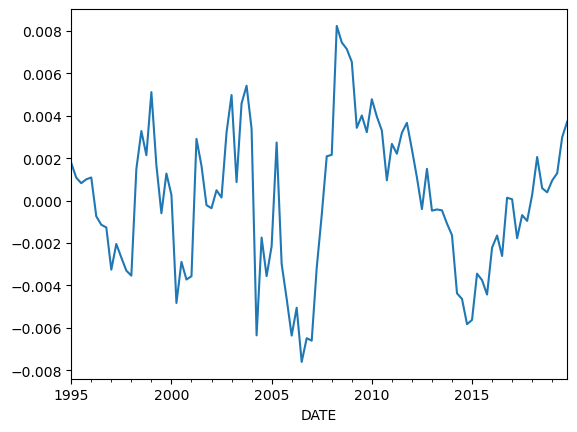

In [23]:
Logw= np.log(merged['w'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(Logw)
w = Logw = cycle
w.plot()

<Axes: xlabel='DATE'>

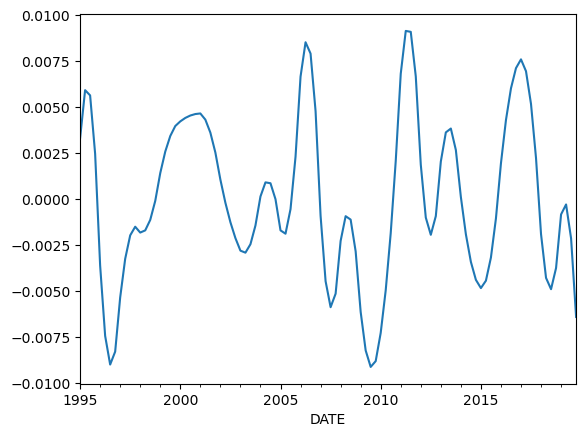

In [24]:
LogN= np.log(merged['N'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogN)
N = LogN = cycle
N.plot()

In [25]:
#now make the trade balance variables 
TB = EX - IM
TBtoY = TB / Y
merged ['TBtoY'] = TBtoY
merged['TBtoY'] = merged['TBtoY'] - merged['TBtoY'].mean()

In [26]:
processed = pd.DataFrame()
processed['Y'] = LogY
processed['C'] = C
processed['I'] = I
processed['K'] = K
processed['TBtoY'] = merged['TBtoY']
processed['N'] = N
processed['r'] = merged['r_quarterly']
processed['w'] = w
processed['R'] = merged['Br_quarterly']
processed

,Y,C,I,K,TBtoY,N,r,w,R
DATE,,,,,,,,,
1995-01-01,0.005956,-0.012950,0.002914,-0.031336,0.010996,0.003314,0.119994,0.001780,0.053912
1995-04-01,-0.003977,-0.006173,0.001990,-0.035218,0.000843,0.005925,0.121158,0.001081,0.048403
1995-07-01,-0.006886,-0.005908,0.001163,-0.004120,-0.002320,0.005641,0.099465,0.000822,0.045496
1995-10-01,-0.006673,-0.008181,0.000447,0.032705,-0.007272,0.002468,0.080456,0.001003,0.042594
1996-01-01,-0.013601,0.000323,-0.000758,-0.082173,0.006296,-0.003618,0.068377,0.001091,0.038789
...,...,...,...,...,...,...,...,...,...
2018-10-01,0.003486,-0.003515,0.001555,-0.032540,0.002773,-0.003751,-0.063157,0.000391,-0.031801
2019-01-01,-0.004496,0.014666,0.002014,-0.003216,-0.015727,-0.000835,-0.063164,0.000951,-0.034574
2019-04-01,-0.000271,-0.003463,0.002408,-0.041605,0.009131,-0.000293,-0.063158,0.001291,-0.035691


(90, 9)
(10, 9)
Y


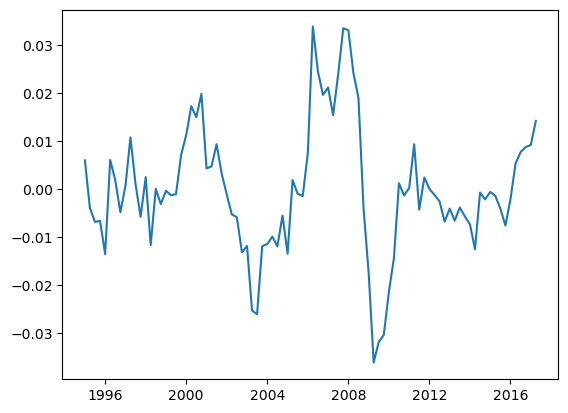

C


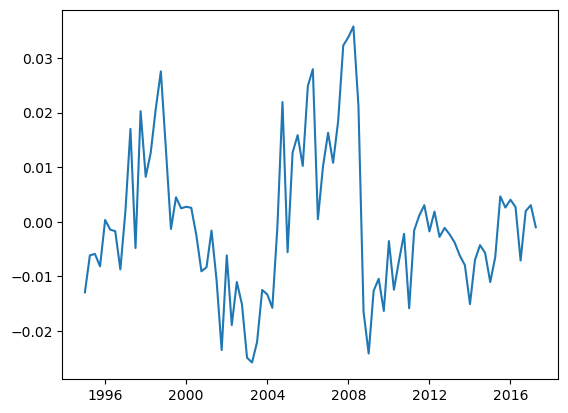

I


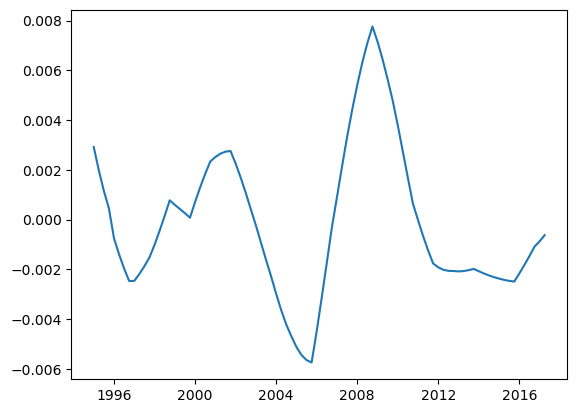

K


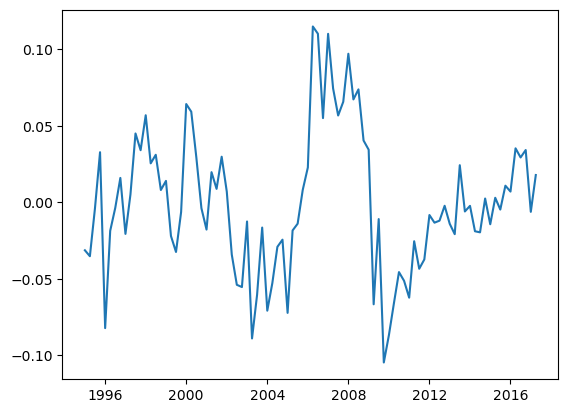

TBtoY


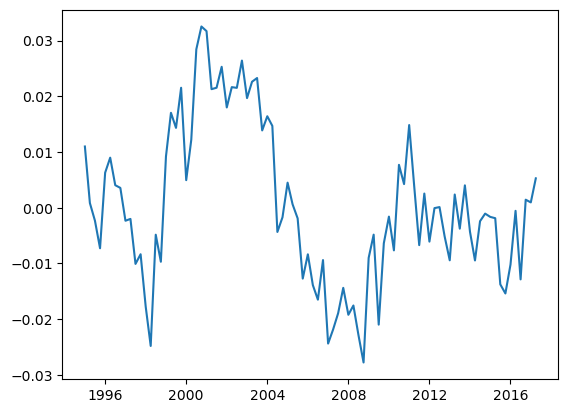

N


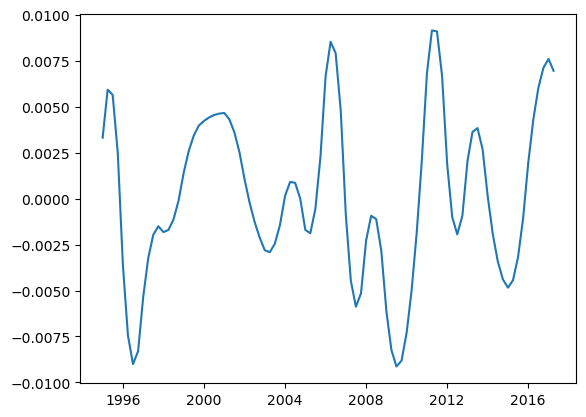

r


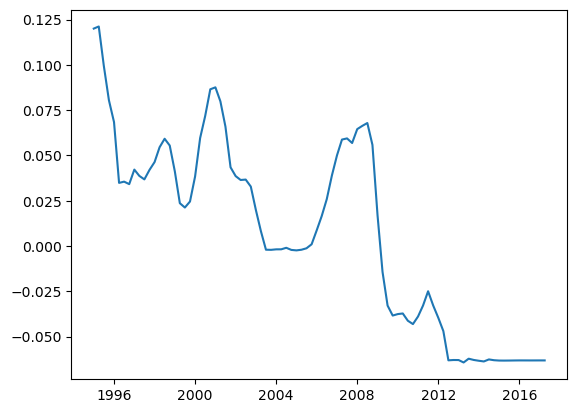

w


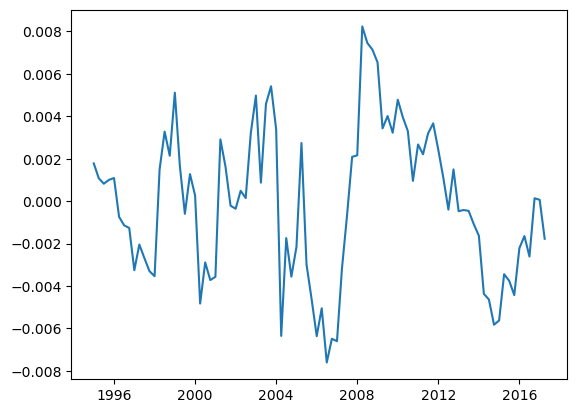

R


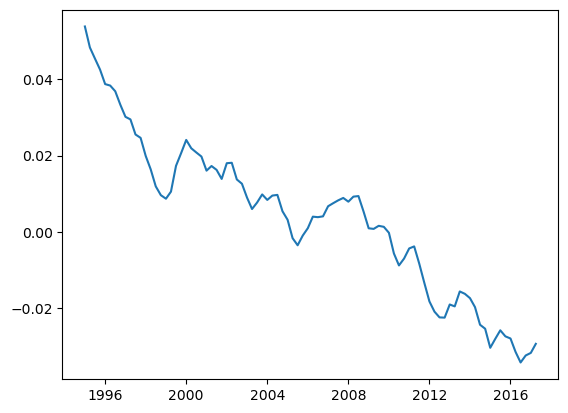

In [74]:
#train/split
n_test=10
processed_train = processed.iloc[:-n_test, :].copy()
processed_test= processed.iloc[-n_test:, :].copy()
print(processed_train.shape)
print(processed_test.shape)
for columns in processed_train.columns:
    print(columns)
    columntrain_data = processed_train[columns].dropna()
    plt.plot(columntrain_data, label=columns)
    plt.show()

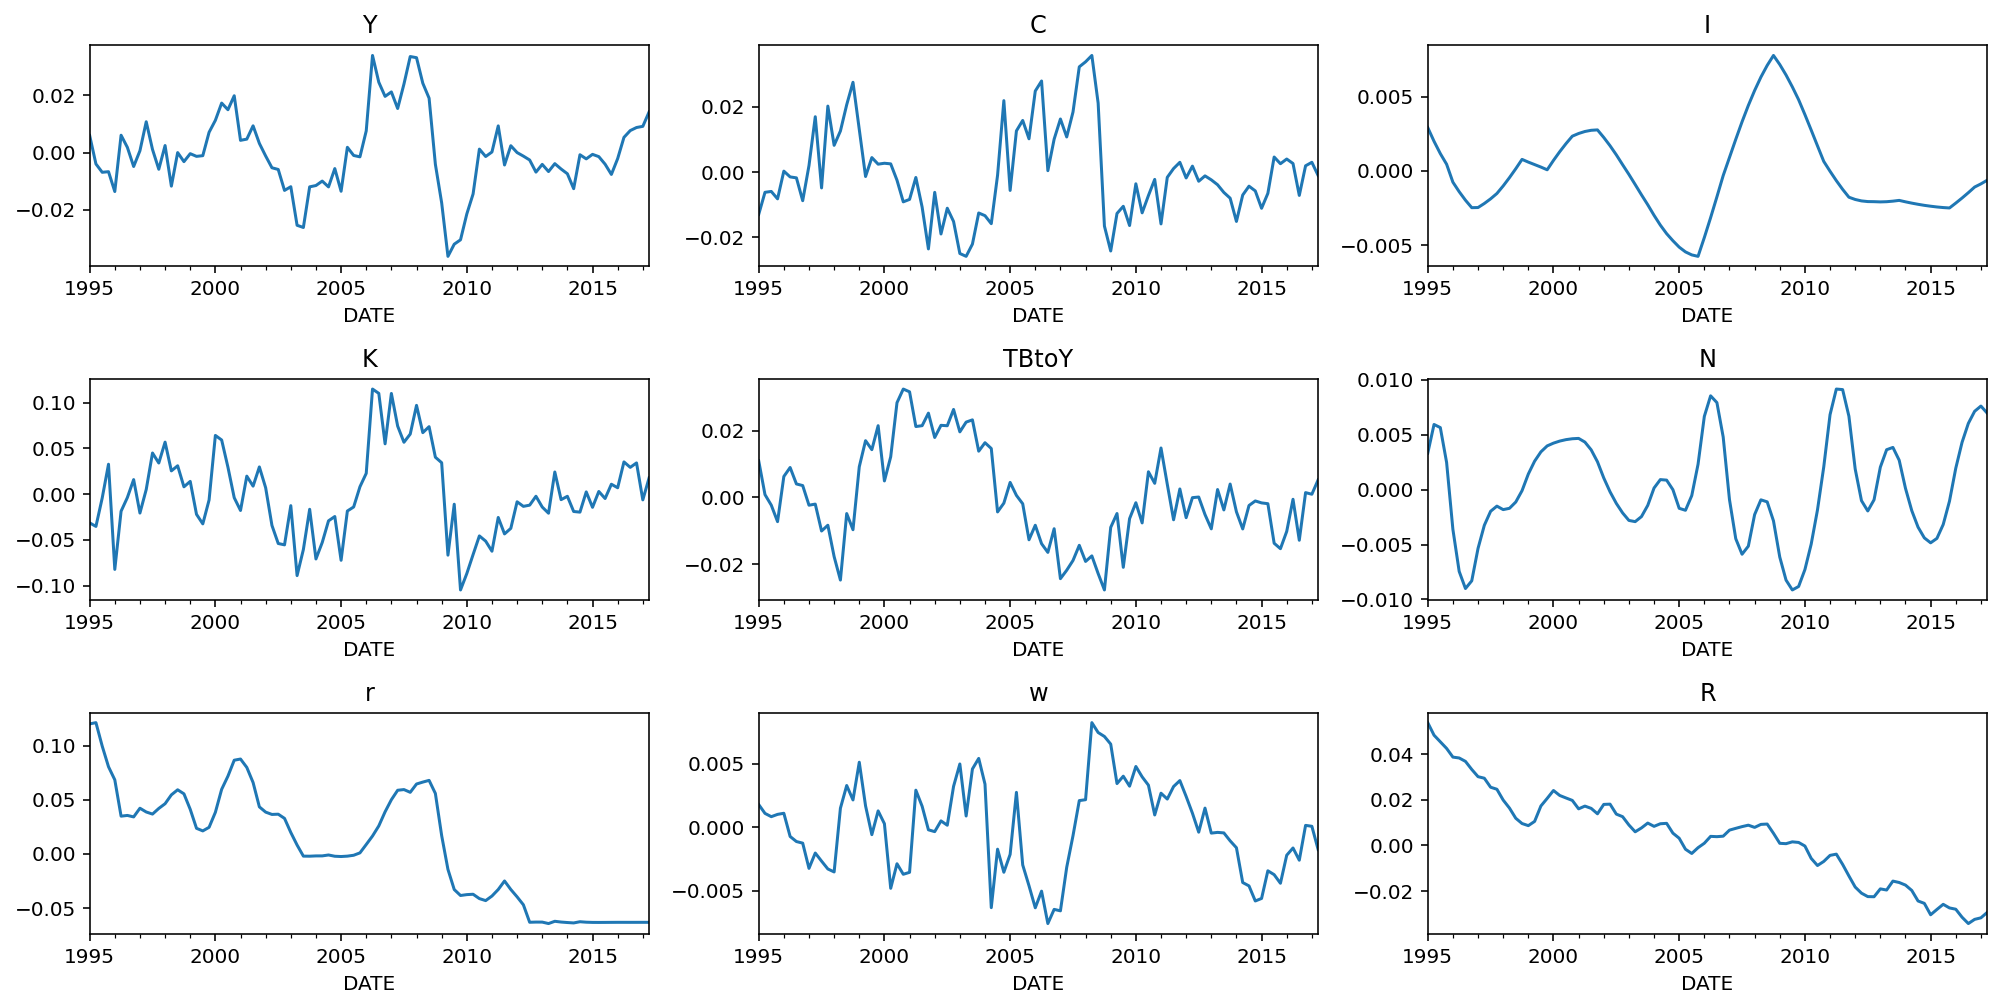

In [28]:
plot_df(processed_train, figsize=(14,9))

Denmark, given that being a small open economy, tends to be influenced by global economic
trends, such as recessions or booms, trade agreements, and international economic conditions.
Pedersen and Ravn (2013) states that over 50% of the volatility in Denmark’s real GDP can be
attributed to foreign shocks. A lot of external variables contributed to the recession that Denmark
experienced following the most recent financial crisis. As can be seen from the first three graphs
of our model, corresponding to the national accounts data, such as Output, Consumption, and
Investment, the first and the second decreased significantly during the 2008-9 financial crisis.
Given that consumers tend to cut consumption and save more during a crisis, our investment
graph is evident for this economic intuition. More precisely, it can be said that the investment
graph has the reverse pattern of consumption and output.


What is most striking is that the most severe fall in output and consumption has been observed
during lockdown, due to the pandemic. While output and consumption shrank by 0.04 and 0.02
in 2008-9, they diminished by 0.08 and 0.06 in 2020, respectively. In addition, the effect of the
financial crisis and the pandemic can be well seen in the Trade Balance graph where the deviation
from the trend corresponds to the same period, namely 2008-9 and 2020. Capital stock, denoted
by K, on the other hand, dropped off more during the financial crisis compared to the pandemic
period by 0.10, and around 0.06, respectively. It is important to note that capital stock could not
reach to its pre-crisis period, which can be interpreted as a slowdown in investment in Denmark
Poghosyan (2018).


When it comes to the graph, which depicts working hours in Denmark between the years 1988
and 2023, it can be seen that working hours considerably fluctuated over time. Although a few
waving can be associated with the reasons above, the rest needs special investigation.Burr et al.
(2003) claims the reduction in working hours in Denmark between 1990 and 2000 was primarily
driven by labor market and societal changes. Besides, Riekhoff et al. (2019) shed light on the
decreasing trend of working hours in Denmark between 1996 and 2016, by showing this decrease
was caused mostly among the 15–29 age group. Another important variable for the labor market,
namely wages, is also presented as a part of our model. The highest wage increase was around
2008-9 by 0.020 with an all-time high. One can conclude that around 2006, the fluctuations fit in a pattern, as the graph suggests. However, the real wage growth has also seen negative parts from
time to time, especially before 2008 Huidrom (2023).


Last but not least, it is beneficial to keep in mind that Denmark is a member of the European
Union. Thus, changes in EU policies, expansions, or contractions of the EU, directly affect the
Danish economy. In this sense, when we look at the graph of interest rates and bond yields, there
is an overall decreasing trend. Starting with the interest rates, taking into account that in early
July 2012, Denmark National Bank lowered its monetary-policy interest rates to historically low
levels in connection with the ECB. The reduction of interest rates to below zero aligns with the
results of our graph. One can say that the negative rate of interest on certificates of deposit was
set solely with consideration to maintaining Denmark’s fixed-exchange-rate policy. The fixed-
exchange-rate policy entails that monetary policy is laid down to stabilize the krone against the
euro Jensen and Spange (2015). Second of all, Danish government bond yields dipped below zero for the first time on the eve
of 2000. Afterwards, this decreasing trend persisted. The IMF Country Report, published in 2022
is optimistic about the issue though. It is claimed that reduced government bond yields may
encourage Danish investors to make foreign investments and increase corresponding primary
income flows.

In [29]:
ADF_test_summary(processed_train, missing = 'drop') 

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.178         -2.850        0.179          0    -4.064      -3.461     -3.157
	Constant            -0.001         -0.303        0.762
	Trend                0.000          0.378        0.707
Constant Only               -0.179         -2.879        0.048          0    -3.506      -2.895     -2.584
	Constant             0.000          0.050        0.960
No Constant                 -0.179         -2.897        0.004          0    -2.591      -1.944     -1.614
                                                      C                                                       
Specification               Coeff          Statistic     P-value      La

In [30]:
description = processed_train.describe()
description

,Y,C,I,K,TBtoY,N,r,w,R
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,-0.000122,-0.000384,-0.000152,-0.000499,0.000503,0.000190,0.007018,-0.000118,0.003628
std,0.013517,0.013606,0.002996,0.045937,0.014122,0.004542,0.052264,0.003553,0.020595
min,-0.036215,-0.025813,-0.005747,-0.104607,-0.027780,-0.009133,-0.064290,-0.007605,-0.034287
25%,-0.006661,-0.008646,-0.002084,-0.025183,-0.009294,-0.002720,-0.040851,-0.002960,-0.012242
50%,-0.001221,-0.001757,-0.000816,-0.004436,-0.001619,-0.000374,0.012604,-0.000075,0.006360
75%,0.006816,0.004365,0.001690,0.029402,0.009152,0.003785,0.045600,0.002367,0.016376
max,0.033882,0.035796,0.007764,0.114811,0.032544,0.009149,0.121158,0.008236,0.053912


In [31]:
correlation_matrix = processed_train.corr()
correlation_matrix

,Y,C,I,K,TBtoY,N,r,w,R
Y,1.000000,0.608142,0.072231,0.744143,-0.154817,0.410524,0.312778,-0.290129,0.056899
C,0.608142,1.000000,-0.066213,0.555802,-0.515572,0.094452,0.208957,-0.146601,0.024666
I,0.072231,-0.066213,1.000000,0.155908,-0.065388,-0.203643,0.424061,0.555677,0.269399
K,0.744143,0.555802,0.155908,1.000000,-0.479633,0.199192,0.293845,-0.265213,0.032013
TBtoY,-0.154817,-0.515572,-0.065388,-0.479633,1.000000,0.220005,0.145024,0.076885,0.242125
N,0.410524,0.094452,-0.203643,0.199192,0.220005,1.000000,0.013700,-0.177599,-0.111354
r,0.312778,0.208957,0.424061,0.293845,0.145024,0.013700,1.000000,0.125974,0.886910
w,-0.290129,-0.146601,0.555677,-0.265213,0.076885,-0.177599,0.125974,1.000000,0.133949
R,0.056899,0.024666,0.269399,0.032013,0.242125,-0.111354,0.886910,0.133949,1.000000


## **The Model**
### **Calibration and Data**
Estimation of the model below requires quarterly data on consumption, investment, rental rate of capital, GDP, labour and wage.

To calibrate our parameters, we refer to the two articles discussed in the literature review section. Starting with the discount factor β, while one finds it to be 0.99, the other records it as 0.9975. For our model, we chose a value of 0.99 as it is commonly used as default in other such paper for computational efficiency. Both papers have calibrated the depreciation of capital stock δ at 0.025, as we do here. As for the share of capital income from GDP, α, both models have also recorded it as 0.3 which we adopt. Labor disutility parameter, ω, is a rather interesting case. While one marks it down as 2.5, the other estimated it at 5.5. As a middle ground, we set ω to 3. Moving to temporary technology shock, Denmark seems to score relatively highly. Indeed, in both papers, the parameter for ρ ranged between 0.8 and 0.85. We set ρ to 0.85. We find ψ in our first article marked down as 0.02, and this is what we adopt for this model. Consequently, ψ² is 0.0004. As for the risk aversion γ, the utility function used in our first article estimates it as log (C ) = 1. We chose a smaller value of 1.5 to fit the model. Finally, as for r*, we calculate it using the following formula rstar =1/(β-1). As such, is set to 0.0101010. 

In [32]:
import sys

sys.path.append("..")

import gEconpy as ge
import gEconpy.plotting as gp

import numpy as np
import sympy as sp

print(f"Running gEconpy version {ge.__version__}")

Running gEconpy version 1.2.1


In [33]:
vars_to_plot = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r', 'w'] 


In [34]:
open_rbc = ge.gEconModel("D:\Macro\Modelo_RBC_.cgn")


Model Building Complete.
Found:
	14 equations
	14 variables
	The following variables were eliminated at user request:
		U_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	11 parameters
		 0 / 11 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [35]:
from gEconpy.classes.time_aware_symbol import TimeAwareSymbol

for var, eq in open_rbc.steady_state_relationships.items():
    sp_var = TimeAwareSymbol(var.split("_")[0], time_index="ss")
    display(sp.Eq(sp_var, eq))

Eq(A_ss, 1.0)

Eq(CA_ss, 0.0)

Eq(C_ss, IIPbar*rstar - delta*(alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)) + ((alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**alpha*(((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**(1 - alpha))

Eq(Cadjcost_ss, 0.0)

Eq(IIP_ss, IIPbar)

Eq(I_ss, delta*(alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))

Eq(K_ss, (alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))

Eq(KtoN_ss, (alpha/(delta + rstar))**(1/(1 - alpha)))

Eq(N_ss, ((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))

Eq(P_ss, 1.0)

Eq(TB_ss, -IIPbar*rstar)

Eq(TBtoY_ss, -IIPbar*rstar*(((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**(alpha - 1)/((alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**alpha)

Eq(U_ss, ((IIPbar*rstar - delta*(alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)) + ((alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**alpha*(((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**(1 - alpha) - (((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**omega/omega)**(1 - gamma) - 1)/((1 - beta)*(1 - gamma)))

Eq(Y_ss, ((alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**alpha*(((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**(1 - alpha))

Eq(lambda_ss, (IIPbar*rstar - delta*(alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)) + ((alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**alpha*(((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**(1 - alpha) - (((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**omega/omega)**(-gamma))

Eq(r_ss, rstar)

Eq(r_ss, rstar)

Eq(u_ss, ((IIPbar*rstar - delta*(alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)) + ((alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**alpha*(((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**(1 - alpha) - (((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**omega/omega)**(1 - gamma) - 1)/(1 - gamma))

Eq(w_ss, (alpha/rstar)**(alpha/(1 - alpha))*(1 - alpha))

In [36]:
for equation in open_rbc.system_equations:
    display(equation)

-psi*(K_t - K_t-1)**2/2 + A_t*K_t-1**alpha*N_t**(1 - alpha) - C_t - K_t + K_t-1*(1 - delta) - TB_t

K_t/N_t - KtoN_t

-TBtoY_t + N_t**(alpha - 1)*TB_t/(A_t*K_t-1**alpha)

-CA_t + IIP_t-1*r_t-1 + TB_t

psi2*(exp(IIPbar - IIP_t) - 1*1) + rstar - r_t

-r_given_t + r_t

-1*psi*(K_t - K_t-1)**2/2 + A_t*K_t-1**alpha*N_t**(1 - alpha) - C_t - IIP_t + IIP_t-1*(r_given_t-1 + 1) - K_t + K_t-1*(1 - delta)

-lambda_t + (C_t - N_t**omega/omega)**(-gamma)

A_t*K_t-1**alpha*lambda_t*(1 - alpha)/N_t**alpha - N_t**(omega - 1)/(C_t - N_t**omega/omega)**gamma

-beta*lambda_t+1*(-alpha*A_t+1*K_t**(alpha - 1)*N_t+1**(1 - alpha) + delta + psi*(2*K_t - 2*K_t+1)/2 - 1) - lambda_t*(psi*(2*K_t - 2*K_t-1)/2 + 1)

-beta*lambda_t+1*(-r_given_t - 1) - lambda_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

-I_t + K_t - K_t-1*(1 - delta)

A_t*K_t-1**alpha*N_t**(1 - alpha) - Y_t

## Solve the Steady State

In [37]:
open_rbc.steady_state()

Steady state found! Sum of squared residuals is 0.0


In [38]:
# Pull out Y_ss and r_ss from the steady state
Y_zero = open_rbc.steady_state_dict['Y_ss']
r_ss = open_rbc.steady_state_dict['r_ss']

In [39]:
# Compute IIP_ss using the formula above
IIP_ss = -processed_train.TBtoY.mean() / r_ss * Y_zero
IIP_ss

-0.16538207943813904

In [40]:
# Set the new IIP_bar parameter
open_rbc.free_param_dict['IIPbar'] = IIP_ss

# Re-solve the steady-state
open_rbc.steady_state()
starting_params = open_rbc.free_param_dict.copy()

Steady state found! Sum of squared residuals is 4.7088998895211425e-32


In [41]:
open_rbc.print_steady_state()

A_ss                1.000
CA_ss               0.000
C_ss                2.612
IIP_ss             -0.165
I_ss                0.710
K_ss               28.403
KtoN_ss            21.436
N_ss                1.325
TB_ss               0.002
TBtoY_ss            0.001
Y_ss                3.323
lambda_ss           0.402
r_given_ss          0.010
r_ss                0.010


## Model Stability 

In [42]:
## Blanchard-Khan conditions check
open_rbc.solve_model(not_loglin_variable=['CA', 'TB', 'TBtoY'])
    


Solution found, sum of squared residuals:  6.493535409640284e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [43]:
open_rbc.check_bk_condition()

Model solution has 4 eigenvalues greater than one in modulus and 4 forward-looking variables.
Blanchard-Kahn condition is satisfied.


,Modulus,Real,Imaginary
0,6.307781e-20,-6.307781e-20,-0.0
1,5.224321e-19,-5.224321e-19,-0.0
2,7.054440e-18,7.054440e-18,0.0
3,7.803447e-18,-7.803447e-18,-0.0
4,7.911886e-01,7.911886e-01,0.0
5,8.500000e-01,8.500000e-01,0.0
6,9.867128e-01,9.867128e-01,0.0
7,1.023747e+00,1.023747e+00,0.0
8,1.276715e+00,1.276715e+00,0.0
9,6.438966e+07,6.438966e+07,0.0


Here, we analyze the results of our Blanchard-Khan conditions. Indeed, it is necessary to fulfill them to ensure the stability of our model and uniqueness of our solutions within the context of a dynamic economic model. Indeed, if we have less unstable eigenvalues than stable eigenvalues, then equilibrium can still be achieved through different channels. However, if our model contains more unstable than stable values, then it is deemed unstable and naturally, unreliable in its entirety. 

At the steady state, our model fulfils the BK conditions. We have four eigenvalues greater than 1 in modulus. However, we have four unstable variables with four forward-looking eigenvalues. This means that for the total number of forward-looking variables, we have an equal number of variables with eigenevalues bigger than 1 in modulus. This ensures that our model has a unique and stable solution path. 

Below is a plot of our eigenvalues:


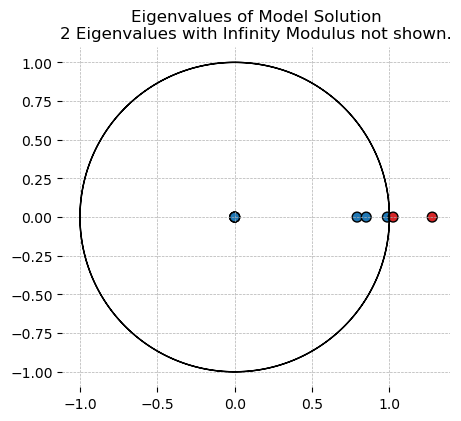

In [44]:
gp.plot_eigenvalues(open_rbc);

## Impulse Response Functions 

In [45]:
irf = open_rbc.impulse_response_function(shock_size=0.04)

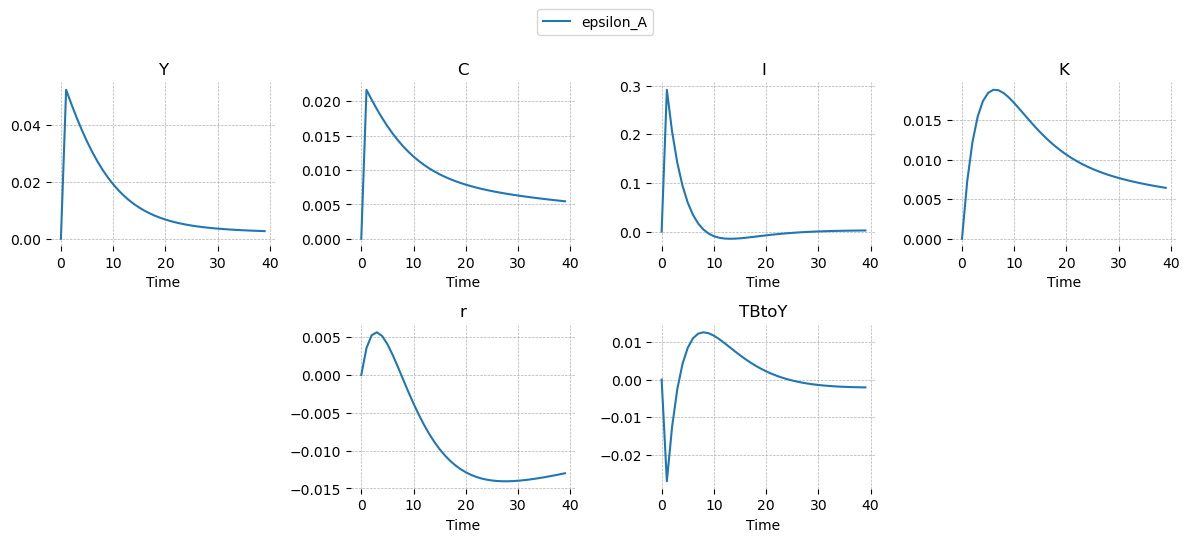

In [46]:
gp.plot_irf(irf, vars_to_plot=['Y', 'C', 'I', 'K', 'r', 'TBtoY'],
            n_cols=4, figsize=(12, 5), legend=True);

## Model Statistics and Simulations


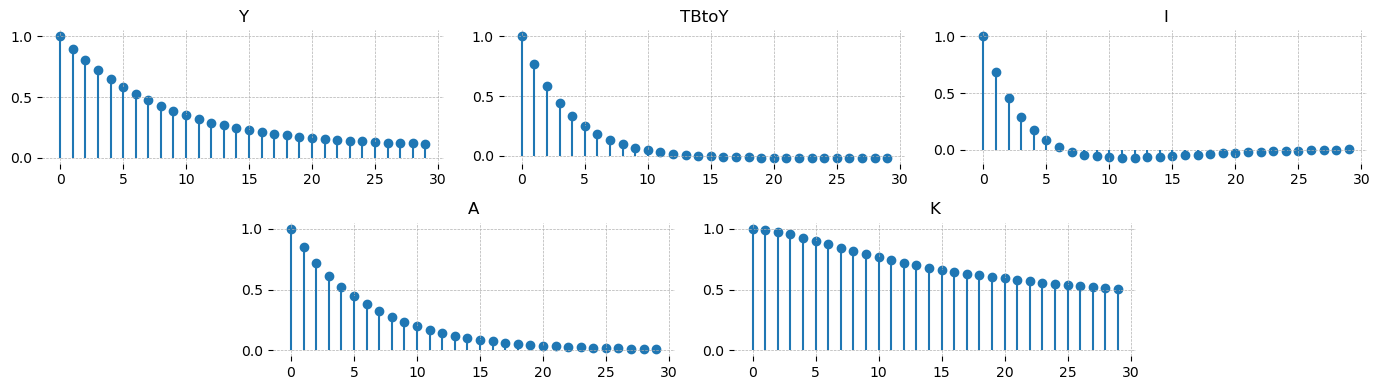

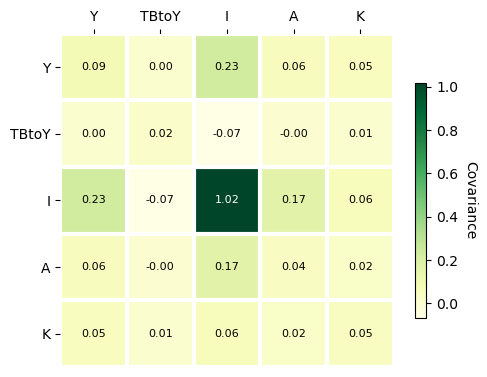

In [47]:
sigma = open_rbc.compute_stationary_covariance_matrix()

acorr_matrix = open_rbc.compute_autocorrelation_matrix(n_lags=30)

gp.plot_acf(acorr_matrix, vars_to_plot=['Y', 'TBtoY', 'I', 'A', 'K'], n_cols=3);

gp.plot_covariance_matrix(sigma, ['Y', 'TBtoY', 'I', 'A', 'K'],
                          figsize=(5,5),
                          cbar_kw=dict(shrink=0.5));

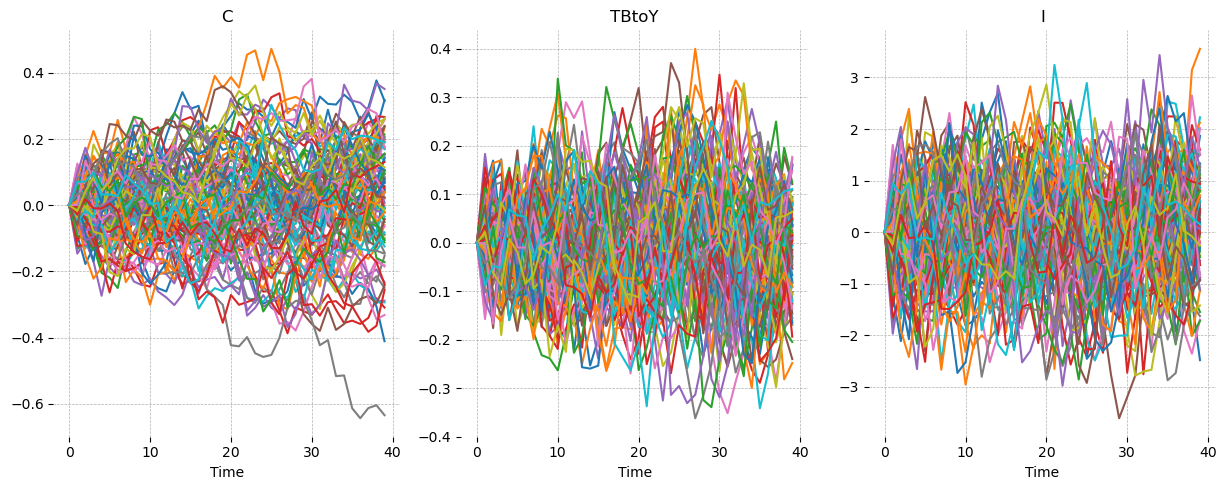

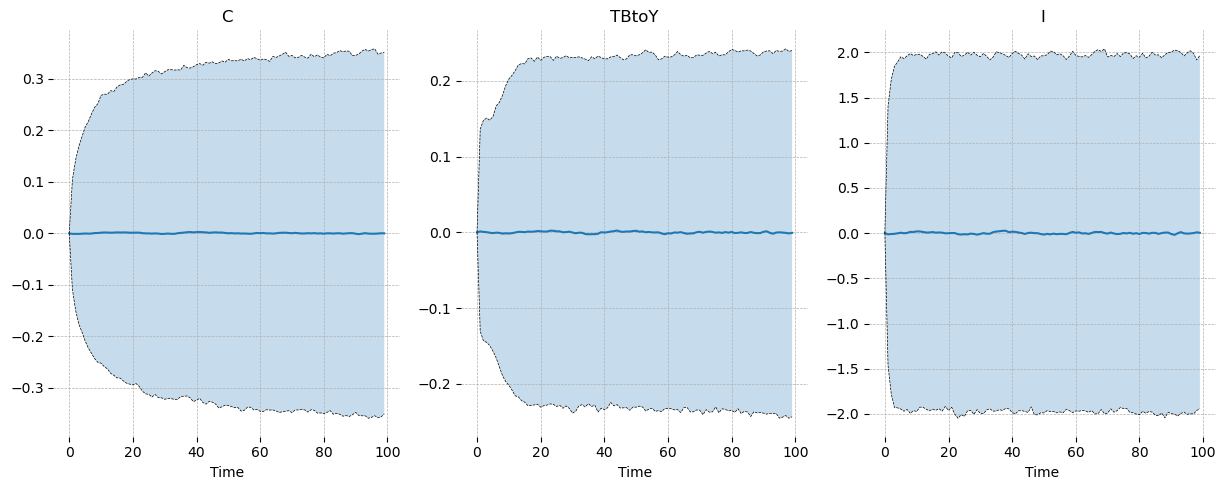

In [48]:
#Simulation 
simulation = open_rbc.simulate(shock_cov_matrix=np.eye(1) * 0.01, n_simulations=100)

gp.plot_simulation(simulation, vars_to_plot=['Y', 'TBtoY', 'I', 'A', 'K'],
                   n_cols=4, figsize=(16, 5));



simulation = open_rbc.simulate(
    shock_cov_matrix=np.eye(1) * 0.01, n_simulations=10_000, simulation_length=100
)
gp.plot_simulation(
    simulation,
    vars_to_plot=['Y', 'TBtoY', 'I', 'A', 'K'],
    ci=0.95,
    n_cols=4,
    figsize=(16, 5),
);

## Estimations


In [49]:
MLEModel = ge.compile_to_statsmodels(open_rbc)

In [61]:
from gEconpy.classes.transformers import PositiveTransformer, IntervalTransformer
open_rbc.free_param_dict.update(starting_params)
param_start_dict = {"rho_A": 0.85,
                    "alpha":0.30,
                    "delta":0.025,
                    "gamma":1.5,
                    "omega":3}


shock_start_dict = {"epsilon_A": 0.1}
noise_start_dict = {'TBtoY':0.01,
                   'Y' : 0.01, 
                   'C': 0.01,
                   'I' : 0.01,
                   'K' : 0.03,
                   'N' : 0.01,
                   'r': 0.001}


# The slope parameter controls the steepness of the gradient around 0 (lower slope = more gentle gradient)
#     "psi2": PositiveTransformer(),
#     "sigma_L": IntervalTransformer(low=1.05, high=10.0, slope=1),
    #     'alpha':IntervalTransformer(low=0.1, high=0.80, slope=1)


# Don't actually pick 0 and 1, because you can get divide by zero errors. Instead pick numbers really close.
param_transforms = {'rho_A':IntervalTransformer(low=1e-4, high=0.9999),
                    'alpha':IntervalTransformer(low=0.1, high=0.5),
                    'delta':IntervalTransformer(low=0.01, high=0.05), 
                    'gamma':IntervalTransformer(low=1.1, high=5.0),
                    'omega':IntervalTransformer(low=1.1, high=5.0)}

# The model 

mle_mod = MLEModel(
    processed_train.dropna(how='all').drop(columns=['w', 'R']),
    param_start_dict=param_start_dict,
    shock_start_dict=shock_start_dict,
    noise_start_dict=noise_start_dict,
    param_transforms=param_transforms,
    shock_transforms=None,  # If None, will automatically transform to positive values only
    noise_transforms=None,  # If None, will automatically transform to positive values only
    initialization="stationary",
    fit_MAP=False
)


C:\Users\90505\miniconda3\envs\econ\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['constant', 'initial_state_cov']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [57]:
#The new fitted values for our parameters are found as follows: 

In [ ]:
import warnings
with warnings.catch_warnings():
    #warnings.simplefilter('ignore')
    mle_res = mle_mod.fit(method="basinhopping", 
                          T=1, 
                          niter=10_000, 
                          niter_success=100, 
                          stepsize=0.1,
                          minimizer={'method':'L-BFGS-B'})



basinhopping step 0: f -7.35841
basinhopping step 1: f -7.35841 trial_f 283.744 accepted 0  lowest_f -7.35841
basinhopping step 2: f -7.35841 trial_f 21571.2 accepted 0  lowest_f -7.35841
basinhopping step 3: f -7.64097 trial_f -7.64097 accepted 1  lowest_f -7.35841
basinhopping step 4: f -6.2275 trial_f -6.2275 accepted 1  lowest_f -7.35841
basinhopping step 5: f -7.31156 trial_f -7.31156 accepted 1  lowest_f -7.35841
basinhopping step 6: f -7.31156 trial_f -6.89591 accepted 0  lowest_f -7.35841
basinhopping step 7: f -7.31156 trial_f -6.35429 accepted 0  lowest_f -7.35841
basinhopping step 8: f -7.31156 trial_f -4.66342 accepted 0  lowest_f -7.35841
basinhopping step 9: f -10.1478 trial_f -10.1478 accepted 1  lowest_f -7.35841
basinhopping step 10: f -10.1478 trial_f -4.53935 accepted 0  lowest_f -7.35841
basinhopping step 11: f -10.1478 trial_f -7.11146 accepted 0  lowest_f -7.35841
basinhopping step 12: f -10.1478 trial_f -1.86597 accepted 0  lowest_f -7.35841
basinhopping step 13:

In [64]:
#The new fitted values for our parameters are presented as follows:

In [65]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      Statespace Model Results                                     
===================================================================================================
Dep. Variable:     ['Y', 'C', 'I', 'K', 'TBtoY', 'N', 'r']   No. Observations:                   90
Model:                                           DSGEModel   Log Likelihood                 348.190
Date:                                     Wed, 03 Jan 2024   AIC                           -670.380
Time:                                             17:57:26   BIC                           -637.882
Sample:                                         01-01-1995   HQIC                          -657.275
                                              - 04-01-2017                                         
Covariance Type:                                       opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.8462      4.514      0.187      0.851      -8.001       9.694
alpha                0.3003     42.936      0.007      0.994     -83.852      84.453
delta                0.0249      2.953      0.008      0.993      -5.763       5.813
gamma                1.5000    530.333      0.003      0.998   -1037.934    1040.934
omega                3.0049    121.853      0.025      0.980    -235.822     241.832
sigma2.epsilon_A     0.0417      7.880      0.005      0.996     -15.403      15.486
sigma2.TBtoY         0.0038      0.023      0.165      0.869      -0.041       0.049
sigma2.Y             0.0057      0.038      0.150      0.880      -0.069       0.080
sigma2.C             0.0049      1.119      0.004      0.997      -2.188       2.198
sigma2.I             0.0938      1.194      0.079      0.937      -2.245       2.433
sigma2.K             0.0083      0.067      0.124      0.901      -0.123       0.139
sigma2.N             0.0035      0.126      0.028      0.978      -0.243       0.250
sigma2.r             1.3443    213.193      0.006      0.995    -416.506     419.194
=========================================================================================================================================
Ljung-Box (L1) (Q):     56.65, 58.50, 46.06, 40.47, 62.26, 80.16, 82.99   Jarque-Bera (JB):   49.75, 22.10, 18.79, 0.82, 2.45, 6.10, 4.74
Prob(Q):                       0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):              0.00, 0.00, 0.00, 0.66, 0.29, 0.05, 0.09
Heteroskedasticity (H):        0.89, 0.41, 1.06, 0.84, 0.18, 2.37, 0.81   Skew:               -1.10, -0.82, 0.98, 0.22, 0.29, -0.64, 0.04
Prob(H) (two-sided):           0.75, 0.02, 0.87, 0.63, 0.00, 0.02, 0.57   Kurtosis:              5.91, 4.80, 4.08, 3.15, 2.45, 3.00, 1.88
=========================================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

In [66]:
#Note that our calibrated parameter values were as follows: β = 0.99, δ = 0.025, α = 0.30, σc = 1.5, σl = 2.5147, ρA = 0.95, σεA = 0.05.

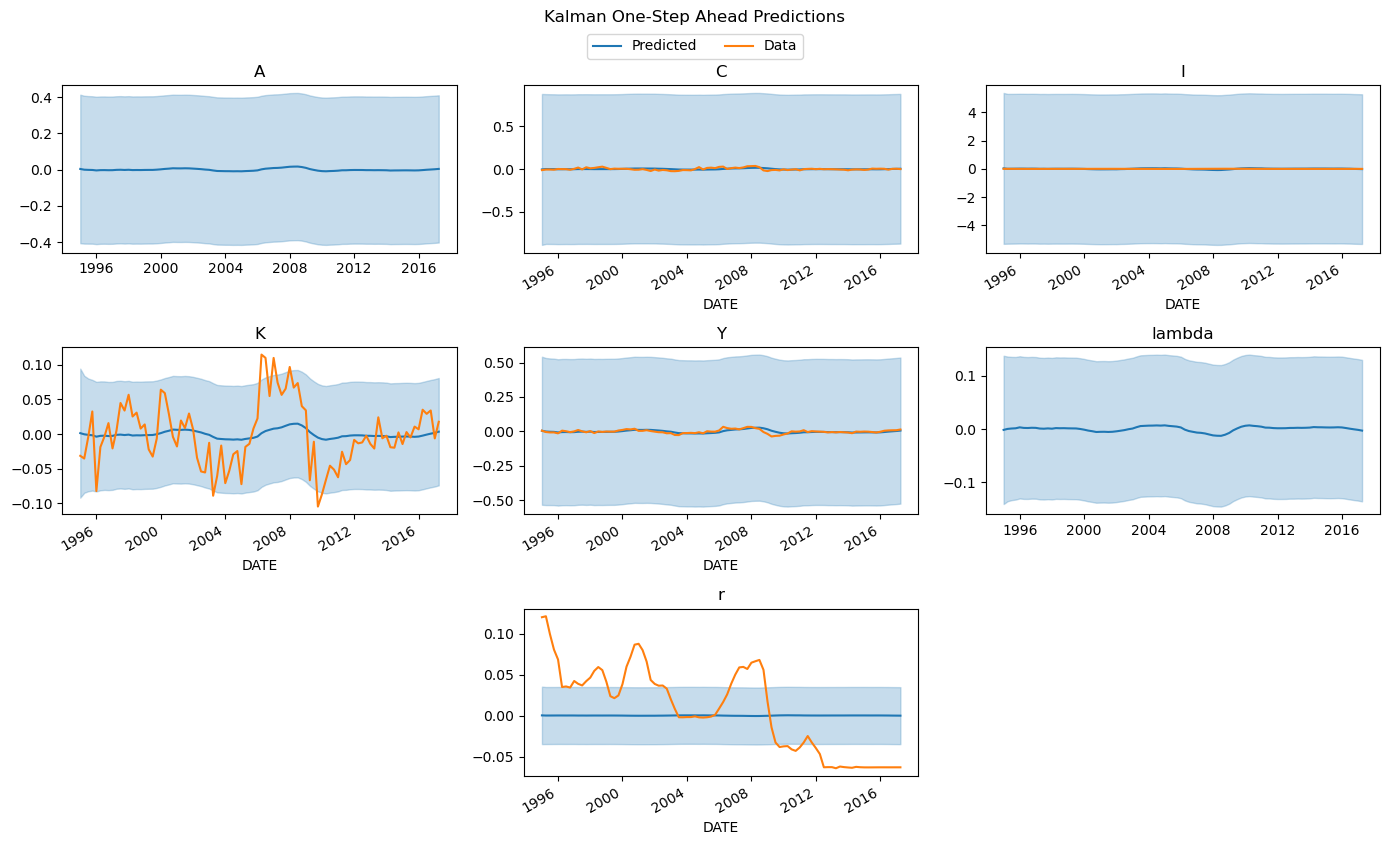

In [67]:
# Plot the results for visual inspection
plot_sm_results(mle_res, processed_train,var_names=vars_to_plot)

In [68]:
#Forecasting
mle_forecast = mle_res.get_forecast(steps=n_test)


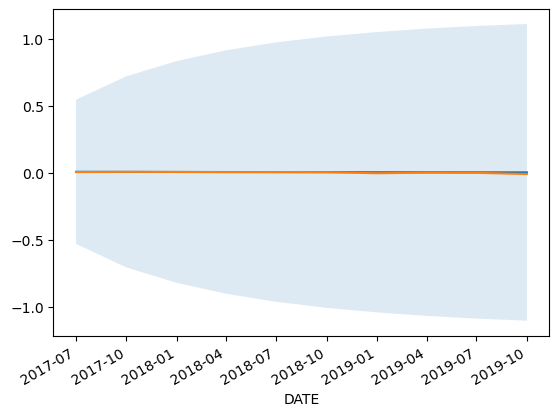

In [75]:
mu = mle_forecast.predicted_mean.Y

# var_pred_mean is the variance, but the 95% CI will be +/- 1.96 * std, so we have to take square root.
sigma = 1.96 * np.sqrt(mle_forecast.var_pred_mean[:,0,0])

fig, ax = plt.subplots()
ax.plot(mu)
ax.fill_between(mu.index, mu - sigma, mu + sigma, alpha=0.15)
processed_test.Y.plot(ax=ax)
plt.show()

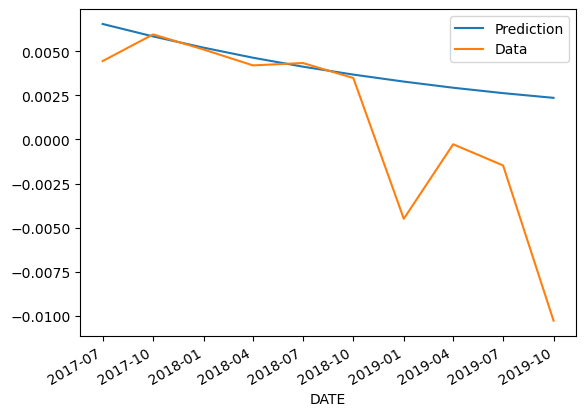

In [78]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
processed_test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

 **References**

Burr, Hermann, Jakob B Bjorner, Tage S Kristensen, Finn Tüchsen, and Elsa Bach, “Trends in the Danish work environment in 1990-2000 and their associations with labor-force changes,”

Scandinavian journal of work, environment & health, 2003, pp. 270–279.
Huidrom, Raju, Wage and Inflation Dynamics in Denmark, International Monetary Fund, 2023.

Jensen, Carina Moselund and Morten Spange, “Interest rate pass-through and the demand
for cash at negative interest rates,” Danmarks Nationalbank Monetary Review 2nd Quarter, 2015,
pp. 55–66.

Pedersen, Jesper, “An estimated DSGE model for Denmark with housing, banking, and financial
frictions,” Technical Report, Danmarks Nationalbank Working Papers 2016.

and Søren Hove Ravn, “What drives the business cycle in a small open economy? Evidence
from an estimated DSGE model of the Danish economy,” Technical Report, Danmarks Nation-
albank Working Papers 2013.

Poghosyan, Mr Tigran, Investment Slowdown in Denmark: Diagnosis and Policy Options, Interna-
tional Monetary Fund, 2018.

Riekhoff, Aart-Jan, Oxana Krutova, and Jouko Nätti, “Working-hour trends in the nordic coun-
tries: convergence or divergence?,” 2019.